#Follow these steps to setup the AWS Bedrock API



1.   Open AWS Console
2.   Go to IAM
3.   Click on Create User
      *   Enter Name
      *   Then Attach Policy
      *   Provide administrative Access and create the user.
4. Now select the create user
5. Click on create the Acces Key
      * Select CLI option
      * Enter Name
      * Download the creadentials in .csv file.

6. Finally note your Region Name.





The AWS SDK for Python (Boto3) provides a Python API for AWS infrastructure services. Using the SDK for Python, you can build applications on top of Amazon S3, Amazon EC2, Amazon DynamoDB, and more.

In [21]:
!pip install boto3

In [22]:
import os

# Set an environment variable
os.environ['AWS_ACCESS_KEY_ID'] = 'AWS_ACCESS_KEY_ID'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'AWS_SECRET_ACCESS_KEY'
os.environ['REGION_NAME'] = 'us-east-1'

#Claude

In [23]:
import boto3
import json
import os

AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
REGION_NAME = os.getenv('REGION_NAME')

boto3.setup_default_session(aws_access_key_id=AWS_ACCESS_KEY_ID,
                            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                            region_name=REGION_NAME)

bedrock = boto3.client(service_name='bedrock-runtime')

body = json.dumps({
    "prompt": "\n\nHuman:explain AI to an 8th grader\n\nAssistant:",
    "max_tokens_to_sample": 512,
    "temperature": 0.1,
    "top_p": 0.9,
})

modelId = 'anthropic.claude-instant-v1'
accept = 'application/json'
contentType = 'application/json'

response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)

response_body = json.loads(response.get('body').read())
response_text = response_body.get('completion')
print(response_text)


 Here is how I would explain AI to an 8th grader:

AI stands for artificial intelligence. It's intelligence that is shown by machines, rather than humans or animals. Computers and robots are examples of machines that can have AI. 

AI allows machines to do things that normally require human intelligence, like understanding language, recognizing images, playing games, and making predictions. Scientists program computers with large amounts of data and algorithms (step-by-step instructions) to help machines learn on their own and solve complex problems.

Some examples of AI that you may have heard of include Siri and Alexa - the voice assistants in phones and smart speakers. They can understand speech, answer questions, and perform tasks using AI. Self-driving cars also use AI to see the road, detect other vehicles and pedestrians, and drive the car without a human driver. 

AI is becoming more common in our daily lives. It's used to recommend movies and products online, translate between

#AI21

In [24]:
import boto3
import json
import os

AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
REGION_NAME = os.getenv('REGION_NAME')

boto3.setup_default_session(aws_access_key_id=AWS_ACCESS_KEY_ID,
                            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                            region_name=REGION_NAME)
prompt_data="""Explain AI to an 8th grader"""

bedrock=boto3.client(service_name="bedrock-runtime")

payload={
    "prompt":prompt_data,
    "maxTokens":512,
    "temperature":0.5,
    "topP":0.8
}
body = json.dumps(payload)
model_id = "ai21.j2-mid-v1"
response = bedrock.invoke_model(
    body=body,
    modelId=model_id,
    accept="application/json",
    contentType="application/json",
)

response_body = json.loads(response.get("body").read())
response_text = response_body.get("completions")[0].get("data").get("text")
print(response_text)


AI stands for artificial intelligence, which is a type of technology that allows computers and machines to perform tasks that normally require human intelligence. For example, AI can help robots understand and react to their environment, or it can help computers make recommendations based on large amounts of data. AI can also be used for many other things, such as speech recognition, language translation, and playing games. It's an exciting field that has a lot of potential for making our lives easier and more efficient.


In [25]:
!pip install streamlit pypdf langchain faiss-cpu

Create a new folder in file named data and upload the pdf file you want to use

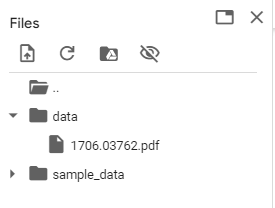

In [26]:
%%writefile app.py

import json
import os
import sys
import boto3
import streamlit as st

## We will be using Titan Embeddings Model To generate Embedding

from langchain_community.embeddings import BedrockEmbeddings
from langchain.llms.bedrock import Bedrock

## Data Ingestion

import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFDirectoryLoader

# Vector Embedding And Vector Store

from langchain_community.vectorstores import FAISS

## LLm Models
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
REGION_NAME = os.getenv('REGION_NAME')

boto3.setup_default_session(aws_access_key_id=AWS_ACCESS_KEY_ID,
                            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                            region_name=REGION_NAME)

## Bedrock Clients
bedrock=boto3.client(service_name="bedrock-runtime")
bedrock_embeddings=BedrockEmbeddings(model_id="amazon.titan-embed-text-v1",client=bedrock)


## Data ingestion
def data_ingestion():
    loader=PyPDFDirectoryLoader("data")
    documents=loader.load()

    # - in our testing Character split works better with this PDF data set
    text_splitter=RecursiveCharacterTextSplitter(chunk_size=10000,
                                                 chunk_overlap=1000)

    docs=text_splitter.split_documents(documents)
    return docs

## Vector Embedding and vect or store

def get_vector_store(docs):
    vectorstore_faiss=FAISS.from_documents(
        docs,
        bedrock_embeddings
    )
    vectorstore_faiss.save_local("faiss_index")

def get_claude_llm():
    ##create the Anthropic Model
    llm=Bedrock(model_id="anthropic.claude-instant-v1",client=bedrock,
                model_kwargs={'max_tokens_to_sample':512})

    return llm

def get_ai21_llm():
    ##create the Anthropic Model
    llm=Bedrock(model_id="ai21.j2-mid-v1",client=bedrock,
                model_kwargs={'maxTokens':512})

    return llm

prompt_template = """

Human: Use the following pieces of context to provide a
concise answer to the question at the end but usse atleast summarize with
250 words with detailed explaantions. If you don't know the answer,
just say that you don't know, don't try to make up an answer.
<context>
{context}
</context

Question: {question}

Assistant:"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

def get_response_llm(llm,vectorstore_faiss,query):
    qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore_faiss.as_retriever(
        search_type="similarity", search_kwargs={"k": 3}
    ),
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)
    answer=qa({"query":query})
    return answer['result']


def main():
    st.set_page_config("Chatbot")

    st.header("Chat with PDF using claude and AI21 models through AWS Bedrock💁")

    user_question = st.text_input("Ask a Question from the PDF Files")

    with st.sidebar:
        st.title("Create Vector Store:")

        if st.button("Ingest"):
            with st.spinner("Processing..."):
                docs = data_ingestion()
                get_vector_store(docs)
                st.success("Done")

    if st.button("Claude Output"):
        with st.spinner("Processing..."):
            faiss_index = FAISS.load_local("faiss_index", bedrock_embeddings, allow_dangerous_deserialization=True)
            llm=get_claude_llm()

            #faiss_index = get_vector_store(docs)
            st.write(get_response_llm(llm,faiss_index,user_question))
            st.success("Done")

    if st.button("AI21 Output"):
        with st.spinner("Processing..."):
            faiss_index = FAISS.load_local("faiss_index", bedrock_embeddings, allow_dangerous_deserialization=True)
            llm=get_ai21_llm()

            #faiss_index = get_vector_store(docs)
            st.write(get_response_llm(llm,faiss_index,user_question))
            st.success("Done")

if __name__ == "__main__":
    main()

Overwriting app.py


In [27]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 1s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


Question: How attention mechanism help in machine translation?

In [28]:
!streamlit run /content/app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.139.134.191
npx: installed 22 in 3.629s
your url is: https://quick-dogs-relax.loca.lt


In [29]:
!pip install sentence-transformers

In [30]:
import os
from getpass import getpass
from langchain.document_loaders import CSVLoader
from langchain_community.embeddings import HuggingFaceEmbeddings

os.environ['HUGGINGFACEHUB_API_TOKEN'] = 'HUGGINGFACEHUB_API_TOKEN'

embeddings = HuggingFaceEmbeddings()

loader = CSVLoader('Book1.csv')

data = loader.load()

for text in data:
  print(text.page_content)


﻿movieId: 1
title: Toy Story (1995)
genres: Adventure|Animation|Children|Comedy|Fantasy
﻿movieId: 2
title: Jumanji (1995)
genres: Adventure|Children|Fantasy
﻿movieId: 3
title: Grumpier Old Men (1995)
genres: Comedy|Romance
﻿movieId: 4
title: Waiting to Exhale (1995)
genres: Comedy|Drama|Romance
﻿movieId: 5
title: Father of the Bride Part II (1995)
genres: Comedy
﻿movieId: 6
title: Heat (1995)
genres: Action|Crime|Thriller
﻿movieId: 7
title: Sabrina (1995)
genres: Comedy|Romance
﻿movieId: 8
title: Tom and Huck (1995)
genres: Adventure|Children
﻿movieId: 9
title: Sudden Death (1995)
genres: Action
﻿movieId: 10
title: GoldenEye (1995)
genres: Action|Adventure|Thriller
﻿movieId: 11
title: American President, The (1995)
genres: Comedy|Drama|Romance
﻿movieId: 12
title: Dracula: Dead and Loving It (1995)
genres: Comedy|Horror
﻿movieId: 13
title: Balto (1995)
genres: Adventure|Animation|Children
﻿movieId: 14
title: Nixon (1995)
genres: Drama
﻿movieId: 15
title: Cutthroat Island (1995)
genres: 

In [31]:
import os
import json
from getpass import getpass
from langchain.document_loaders import CSVLoader
from langchain_community.embeddings import HuggingFaceEmbeddings

# Setting up the environment variable for the API token securely
os.environ['HUGGINGFACEHUB_API_TOKEN'] = 'HUGGINGFACEHUB_API_TOKEN'

# Initialize embeddings
embeddings = HuggingFaceEmbeddings()

# Load data
loader = CSVLoader('Book1.csv')
data = loader.load()

# Preparing data for embedding
texts = []
for doc in data:
    content_dict = {line.split(': ')[0]: line.split(': ')[1] for line in doc.page_content.split('\n') if line}
    title_genres = f"{content_dict['title']} {content_dict['genres'].replace('|', ', ')}"
    texts.append(title_genres)

# Generate embeddings
embedded_docs = embeddings.embed_documents(texts)

# Prepare JSON data
# Here we assume `embedded_docs` is a list of lists directly usable in JSON
json_data = [{"text": text, "embedding": emb} for text, emb in zip(texts, embedded_docs)]

# Save to JSON file
with open('movie_embeddings.json', 'w') as f:
    json.dump(json_data, f, indent=4)

print("Embeddings saved to 'movie_embeddings.json'.")


Embeddings saved to 'movie_embeddings.json'.


In [32]:
# Define your query
query = "War"

# Generate embedding for the query
query_embedding = embeddings.embed_documents(query)

# Print the embedding
print(query_embedding[0])


[-0.03094925731420517, 0.04549365118145943, 0.002726303180679679, -0.00466806860640645, -0.016666729003190994, 0.019349751994013786, -0.06845948845148087, 0.0054322793148458, 0.039052192121744156, 0.004676102660596371, 0.028814256191253662, -0.0012539708986878395, 0.05838324874639511, -0.04110730439424515, 0.049435511231422424, -0.0648702010512352, 0.02836500108242035, -0.0035963833797723055, -0.08744730800390244, -0.03709191828966141, -0.05664432421326637, -0.0031323351431638002, -0.05786461383104324, -0.01401888020336628, -0.021368686109781265, -0.044461049139499664, 0.0037691560573875904, -0.013847708702087402, -0.03602798655629158, -0.005491967312991619, 0.03841716796159744, -0.026538338512182236, 0.017232898622751236, -0.04168539121747017, 2.2503377294924576e-06, -0.029321040958166122, -0.0008236131980083883, -0.02940136380493641, 0.03090236708521843, -0.015995152294635773, -0.07118174433708191, 0.023652134463191032, -0.020327555015683174, 0.030445020645856857, 0.01986156404018402

In [33]:
!pip install rockset

In [34]:
"""
SELECT
  text,
  embedding,
  APPROX_DOT_PRODUCT(embedding, VECTOR_ENFORCE(:query_embedding, 768, 'float')) as similarity
FROM
    commons.data d

ORDER BY similarity DESC
LIMIT :limit;
"""

"\nSELECT\n  text,\n  embedding,\n  APPROX_DOT_PRODUCT(embedding, VECTOR_ENFORCE(:query_embedding, 768, 'float')) as similarity\nFROM\n    commons.data d\n\nORDER BY similarity DESC\nLIMIT :limit;\n"

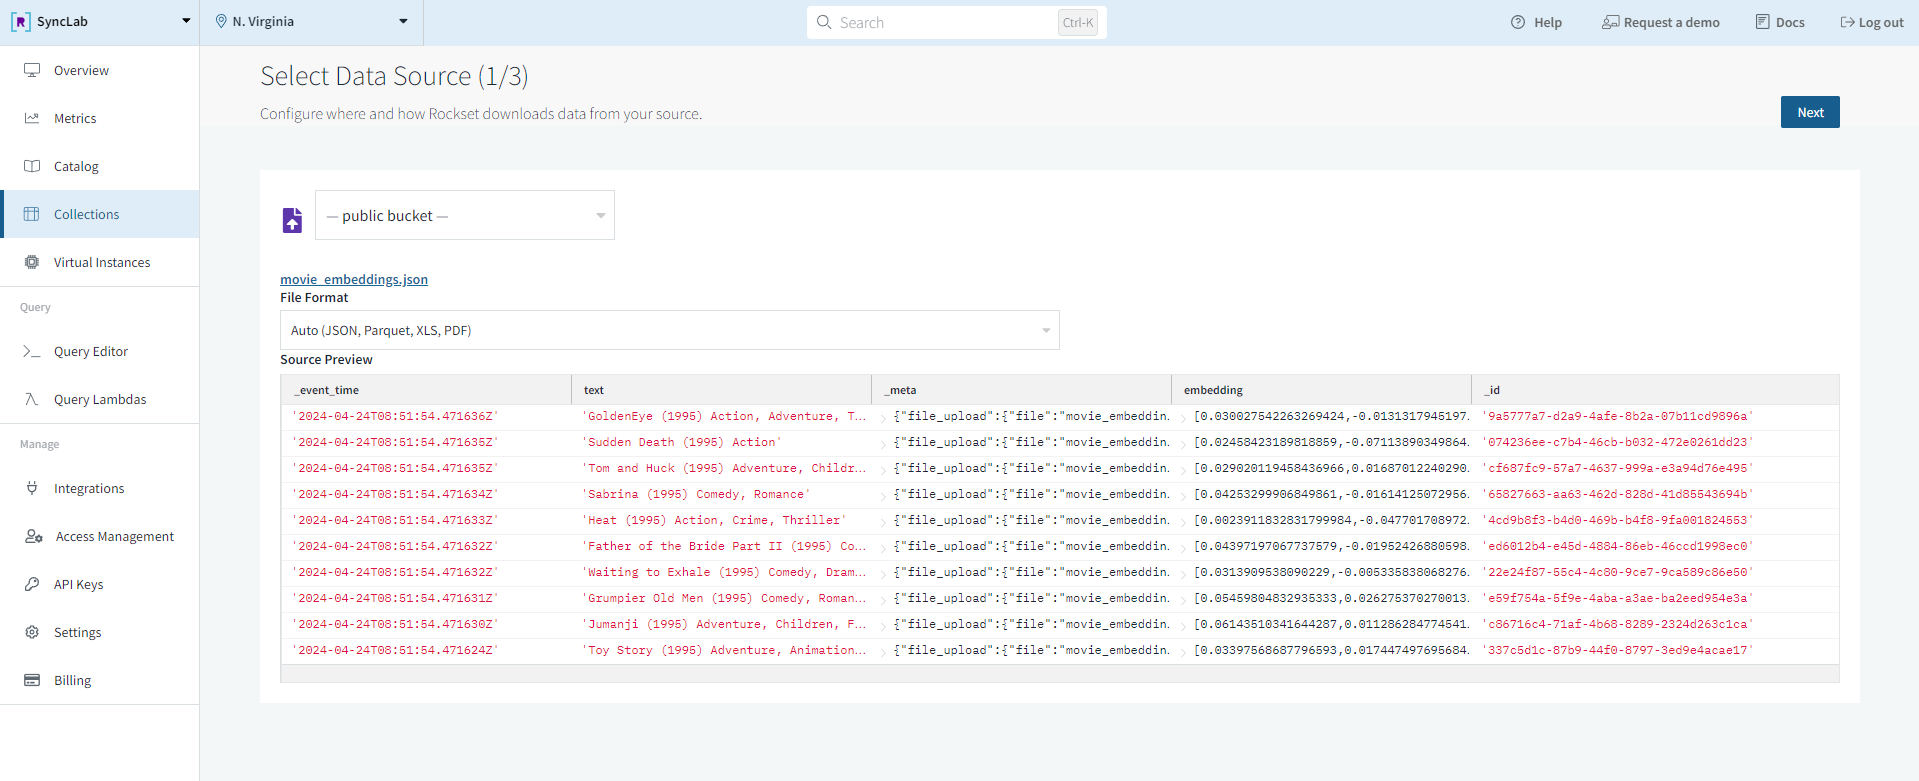

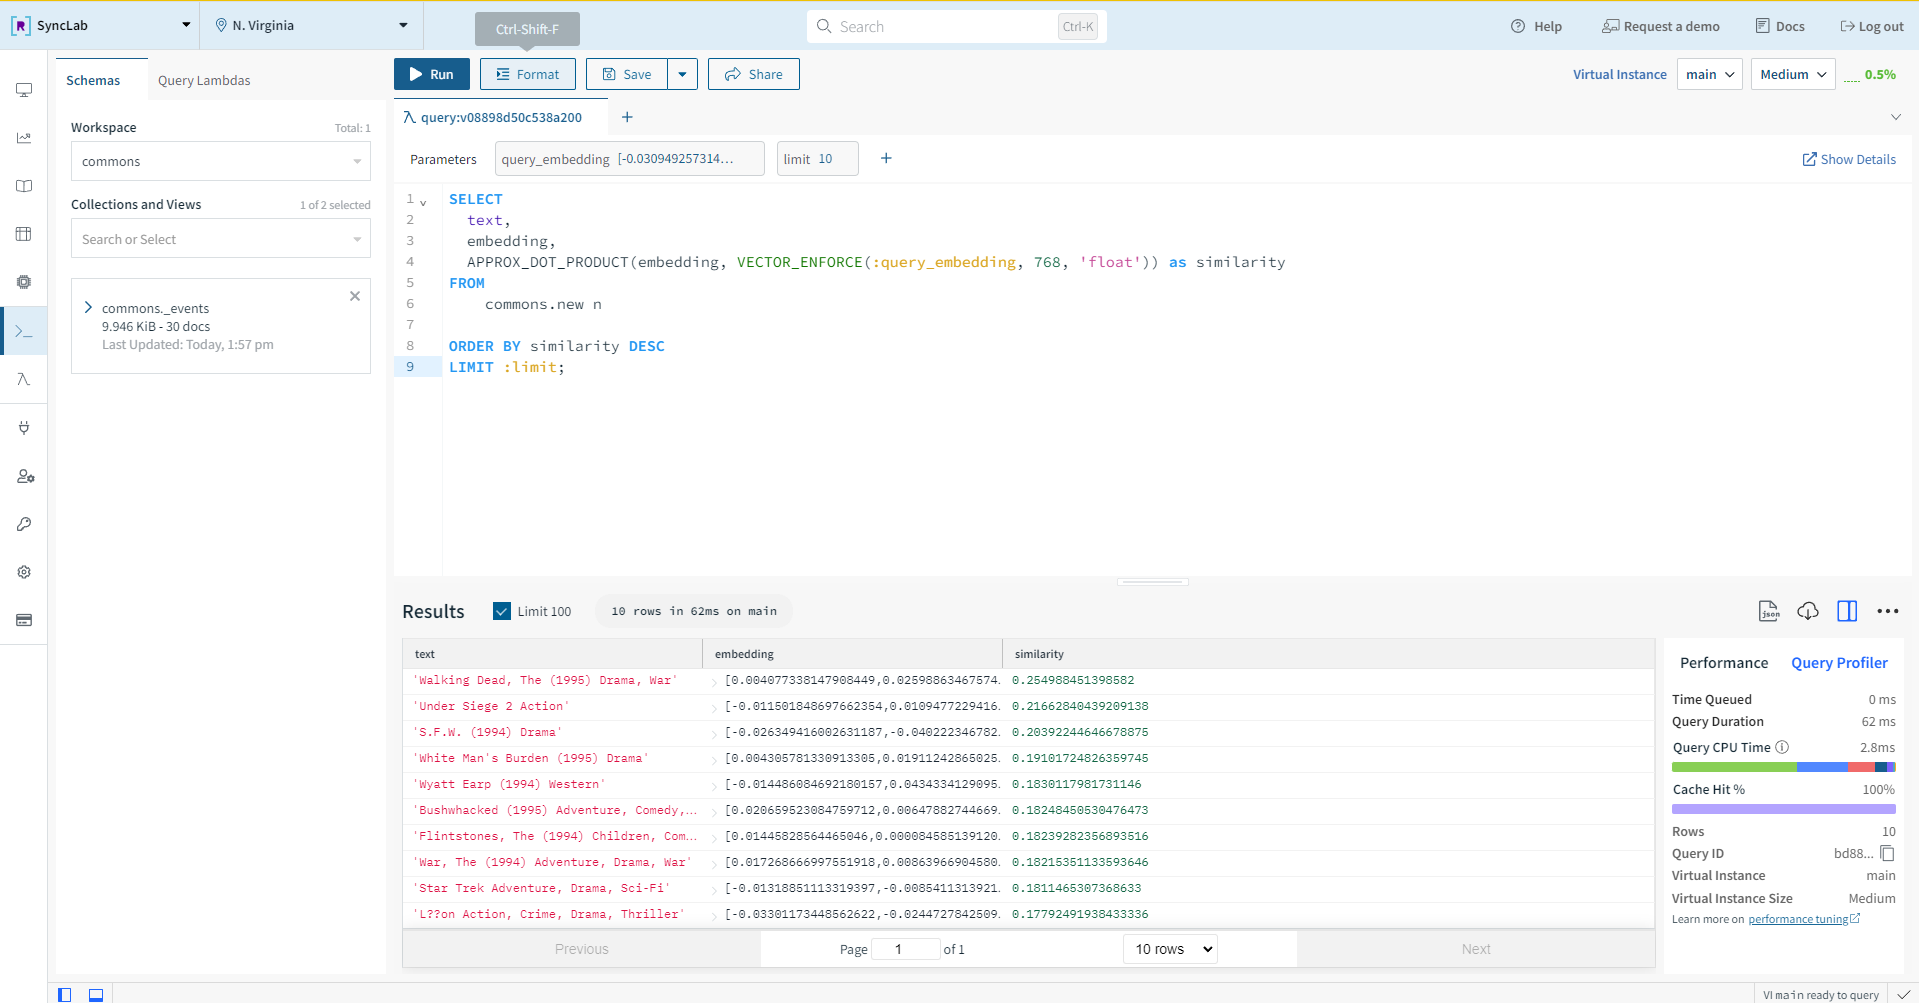

In [35]:
import os

# Set an environment variable
os.environ['AWS_ACCESS_KEY_ID'] = 'AWS_SECRET'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'AWS_SECRET_ACCESS_KEY'
os.environ['REGION_NAME'] = 'us-east-1'

In [39]:
import os
os.environ["ROCKSET_API_KEY"] = "ROCKSET_API_KEY"


In [40]:
import rockset
from rockset import RocksetClient, Regions
from rockset.models import QueryLambdaTag
import os
import json
import boto3
from langchain_community.embeddings import HuggingFaceEmbeddings

# Setting up the environment variable for the API token securely
os.environ['HUGGINGFACEHUB_API_TOKEN'] = 'HUGGINGFACEHUB_API_TOKEN'

# Initialize embeddings
embeddings = HuggingFaceEmbeddings()

# Get the Rockset API key from environment variables
rockset_key = os.environ.get('ROCKSET_API_KEY')
region = Regions.use1a1

def retrieve_information(region, rockset_key, search_query_embedding):
    print("\nRunning Rockset Queries...")
    rs = RocksetClient(api_key=rockset_key, host=region.value)

    api_response = rs.QueryLambdas.execute_query_lambda_by_tag(
        workspace="commons",
        query_lambda="query",
        tag="latest",
        parameters=[
            {
                "name": "embedding",
                "type": "array",
                "value": str(search_query_embedding)
            }
        ]
    )
    records_list = []

    for record in api_response["results"]:
        record_data = {
            "text": record['text']
        }
        records_list.append(record_data)

    return records_list

def rag(query, retrieved_documents):
    # Setup AWS credentials for using Boto3 with the Claude model
    AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
    AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
    REGION_NAME = os.getenv('REGION_NAME')

    boto3.setup_default_session(aws_access_key_id=AWS_ACCESS_KEY_ID,
                                aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                                region_name=REGION_NAME)

    # Create a client for the 'bedrock-runtime' service
    bedrock = boto3.client(service_name='bedrock-runtime')

    # Create a single string from retrieved documents
    information = ' '.join([doc['text'] for doc in retrieved_documents])

    # Create body for the Claude model invocation
    body = json.dumps({
        "prompt": f"\n\nHuman:you will provide a 5 moive names with genres you have to explain them. Respond according to the provided information. Question: {query}. \nInformation: {information}\n\nAssistant:",
        "max_tokens_to_sample": 512,
        "temperature": 0.1,
        "top_p": 0.9,
    })

    modelId = 'anthropic.claude-instant-v1'
    accept = 'application/json'
    contentType = 'application/json'

    # Invoke the model and get the response
    response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response['body'].read())
    content = response_body.get('completion')

    return content

# Example use case
query = 'Action'
search_query_embedding = embeddings.embed_documents(query)

records_list = retrieve_information(region, rockset_key, search_query_embedding[0])
output = rag(query=query, retrieved_documents=records_list)

print(output)



Running Rockset Queries...
 Here are 5 movie names with the genre of Action:

1. Under Siege 2: Dark Territory (1995)
This is an action thriller film directed by Geoff Murphy. It stars Steven Seagal as former SEAL Casey Ryback, who must stop a group of terrorists who have hijacked a U.S. nuclear missile submarine. Lots of intense action sequences as Ryback works to save the submarine and prevent the terrorists from launching any missiles.

2. Star Trek (1994)  
This film brought the popular Star Trek franchise to the big screen. It is an action-packed sci-fi adventure directed by Nicholas Meyer. The crew of the USS Enterprise must stop a rogue Romulan from destroying the Federation. Exciting space battles and hand-to-hand combat scenes. 

3. L??on (1994)
A crime thriller directed by Luc Besson. It stars Jean Reno as the professional assassin Leon and a young Natalie Portman. When her family is murdered, Portman's character seeks Leon's help in learning his trade and getting revenge. I

In [41]:
%%writefile _app.py
import streamlit as st
import rockset
from rockset import RocksetClient, Regions
import os
import json
import boto3
from langchain_community.embeddings import HuggingFaceEmbeddings

os.environ['HUGGINGFACEHUB_API_TOKEN'] = 'HUGGINGFACEHUB_API_TOKEN'

embeddings = HuggingFaceEmbeddings()

# Initialize Rockset and AWS settings
rockset_key = os.environ.get('ROCKSET_API_KEY')
region = Regions.use1a1
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
REGION_NAME = os.getenv('REGION_NAME')

def retrieve_information(region, rockset_key, search_query_embedding):
    print("\nRunning Rockset Queries...")
    rs = RocksetClient(api_key=rockset_key, host=region.value)
    api_response = rs.QueryLambdas.execute_query_lambda_by_tag(
        workspace="commons",
        query_lambda="query",
        tag="latest",
        parameters=[
            {"name": "embedding", "type": "array", "value": str(search_query_embedding)}
        ]
    )
    records_list = []
    for record in api_response["results"]:
        records_list.append({"text": record['text']})
    return records_list

def invoke_model(query, retrieved_documents):
    boto3.setup_default_session(aws_access_key_id=AWS_ACCESS_KEY_ID,
                                aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                                region_name=REGION_NAME)
    bedrock = boto3.client(service_name='bedrock-runtime')
    information = ' '.join([doc['text'] for doc in retrieved_documents])
    body = json.dumps({
        "prompt": f"\n\nHuman:You will provide 5 moives names with genres you have to explain them. Question: {query}. \nInformation: {information}\n\nAssistant:",
        "max_tokens_to_sample": 512,
        "temperature": 0.1,
        "top_p": 0.9,
    })
    modelId = 'anthropic.claude-instant-v1'
    accept = 'application/json'
    contentType = 'application/json'
    response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response['body'].read())
    return response_body.get('completion')

# Streamlit user interface
st.title('Movie Genre Explanation')
genre = st.text_input('Enter a movie genre:', 'Comedy')

if st.button('Generate'):
    search_query_embedding = embeddings.embed_documents(genre)
    records_list = retrieve_information(region, rockset_key, search_query_embedding[0])
    if records_list:
        output = invoke_model(genre, records_list)
        st.text_area("Generated Explanation:", value=output, height=500)
    else:

        st.error("No records found for the provided genre.")



Writing _app.py


In [42]:
!streamlit run /content/_app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.139.134.191
npx: installed 22 in 3.51s
your url is: https://quick-pens-judge.loca.lt
